# 2022 Systematic Trading Education Ceritificate Skeleton Code Lecture 1


## Lecture 1
In this lecture we will be focussing on developing code for both a relative and time series momentum strategies. This lecture will also focus on introducing QT Capital's own skeleton code for backtesting strategies. Note that in order to access financial price data we use the module [yfinance](https://pypi.org/project/yfinance/), which has to be first installed using the Python command pip install done below. The yfinance module allows for the easy pulling of data from yahoo finance which will provide us with asset price data for the first and second lectures.

In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
# the usual imports along with yfinance and a few others
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

## The Parent Class and Evaluation method.
In the code below we define the Strategies class which is a class containing all basic features that our individual backtesting strategy classes will inherit from.

These basic features include:

- the **init method** which defines the asset tickers that the strategy will be focussed on.
- the **import data method** that will import data for a given start and end date using the yfinance module as mentioned earlier.
- the **backtest method** that defines the class variable `self.strat` which is the pandas data frame of values representing the strategy. This is left empty as it will be filled in in the child class.
- the **evaluate method** which calculates the cumulative returns of the given strategy, plots a chart of the cumulative returns and calculates the sharpe ratio of the strategy.
(note that one task this week will be to write code in the evaluate method so that it also returns the sortino ratio)

## Task 3: Calculation of the Sortino Ratio
As was shown in the powerpoint slides for lecture one we have 2 methods for evaluting risk adjusted returns; the Sharpe and Sortino ratios. The code for calculating the Sharpe ratio has already been written below and the task is to then adapt this code to calulate the Sortino ratio (where +ve volatility is ignored).

In [28]:
class Strategies():
  """
  A class that contains code that strategies later on will inherit from.
  params:
  -----
  codes = list of stock short codes
  -----
  """
  def __init__(self, codes):
    self.codes = codes
    self.strat = pd.DataFrame()
    self.data = pd.DataFrame()

  def import_data(self, start_date, end_date):
    """downloads all data for each backtest from yahoo Finance."""
    data = yf.download(self.codes, start_date, end_date)
    # if only one stock code is entered data is reformated so that
    # it is the same format as when multiple stocks are entered
    if len(self.codes) == 1:
      data.columns = [data.columns, self.codes*len(data.columns)]
    #returns data where any row containing NAN values is removed
    return data.dropna()

  def backtest(self, start_date, end_date):
    """
    Returns a list with elements of a time series' from yahoo finance as well as
    an array of values between -1 and 1 that represent the strategy over the giv
    en period with 1 representing a long postion in one stock, 0 representing a
    neutral postion and -1 representing a short position.
    params:
    -----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    -----
    """
    # sets up a dataframe to contain all strategy info for each stock at each 
    # time index
    self.data = self.import_data(start_date, end_date)
    self.strat = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]),
                              columns = self.codes, index = self.data.index)
  
  def evaluate(self, start_date, end_date, fig_strat=True, fig_other=False,
               percentage_risk_free_rate = 0.1, **kwargs):
    """
    returns a dataframe with columns including the daily returns of the portfolio,
    the cumulative returns, the sharp ratio and all relevant plots of both the 
    stock price of each stock 
    and the strategy.
    params:
    ----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    fig = boolean variable that can be used to produce figures
    risk_free_rate = average rate of return on a very safe government issued bond
                     used to calculate the sharpe ratio with
    **kwargs are any specific keyword arguments that can be passed to the
    backtesting function to allow for comparison of the backtest for different
    possible parameters defined in the subclass.
    ----
    """
    # run the backtest function and define the stock price data to be once again
    # data and the signals strat
    self.strat = self.backtest(start_date, end_date, **kwargs)

    # convert the monthly risk free rate to the daily rate for use
    # when calculating Sharpe and sortino ratios
    daily_rate = (1+ percentage_risk_free_rate/100)**(1/20) - 1
    
    # sets up a new dataframe which will give the returns of the portfolio
    return_df = pd.DataFrame(columns= ["daily returns", "cumulative returns"],
                                  index = self.data.index)
    return_df["daily returns"][0] = 0
    
    # loops through the remaining dates and calculates the return across 
    # the portfolio
    for i in range(1, len(self.data)):
      return_df["daily returns"][i] = sum(100*self.strat[c][i-1]*(self.data["Adj Close"][c][i] - self.data["Adj Close"][c][i-1]) 
                                               /self.data["Adj Close"][c][i-1] for c in self.codes)
    # calculates the cumulative return for each date
    return_df["cumulative returns"] = ((return_df["daily returns"]/100+1).cumprod()-1)*100
    return_df.dropna()

    # calculates the length of time for which the strategy is inactive to begin with
    zero_count = 0
    while True:
      if sum(abs(self.strat[c].iloc[zero_count]) for c in self.codes):
        break
      zero_count += 1
    
    # calculates the Sharpe ratio not including the first period of inactivity
    sharpe  = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df[zero_count:]) * daily_rate) /
                    return_df["daily returns"][zero_count:].std())


    sortino = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df[zero_count:]) * daily_rate) /
                    return_df[return_df["daily returns"] < 0]["daily returns"][zero_count:].std())
    
    
    # plots figures if fig TRUE
    if fig_strat:
      # plot of strategy returns
      plt.figure()
      plt.title("Strategy Backtest from "+ start_date+" to "+end_date)
      plt.plot(return_df["cumulative returns"])
      plt.show()

    if fig_other:
      # plot of all individual stocks
      for c in self.codes:
        plt.figure()
        plt.title("Buy and hold from "+ start_date+" to "+end_date+" for "+str(c))
        plt.plot(((self.data["Adj Close"][c].pct_change()+1).cumprod()-1)*100)
        plt.show()
    
    return [return_df, sharpe, sortino]


## Strategy Specific Classes
Each strategy will have to have at a minimum a specific backtesting method defined in the subclass. This method is where the trading algorithm will be implemented and will return a pandas `DataFrame` with an index of all trading dates, columns for each stock in the backtest and data containing values between -1 and 1 representing the positon in each asset at each date.

## Buy and Hold Implementation
The first strategy example that we will brifly look at is simply buying and holding each selected asset with an equal weighting. This is acheived by first defining a pandas dataframe full of ones and then dividing through by the number of tickers (or codes). Although this isn't much of an algorithm, it is useful for seeing how the skeleton code works. 

In [29]:
class StrategyBuyAndHold(Strategies):
    """
    This strategy as the name suggests buys and holds an equal amount of each security
    """
    def backtest(self, start_date, end_date):
      Strategies.backtest(self, start_date, end_date)
      # creates a normalized set of weightings representing a buy and hold strat
      # with each column summing to one 
      return pd.DataFrame(data = (np.ones([len(self.data), len(self.codes)])
                    /len(self.codes)), columns = self.codes)
      


[*********************100%***********************]  1 of 1 completed


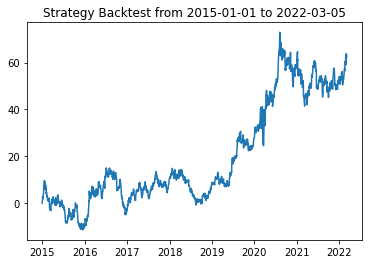

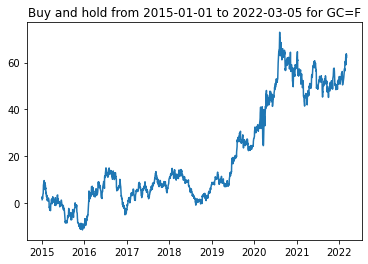

[           daily returns cumulative returns
 Date                                       
 2015-01-02             0                0.0
 2015-01-05      1.509277           1.509277
 2015-01-06      1.279178           2.807761
 2015-01-07      -0.71353           2.074197
 2015-01-08     -0.181724           1.888704
 ...                  ...                ...
 2022-02-25     -2.005089          59.064081
 2022-02-28      0.683807          60.151773
 2022-03-01      2.263873          63.777405
 2022-03-02     -1.106878          61.964589
 2022-03-03      0.702796          63.102869
 
 [1803 rows x 2 columns],
 0.5138879044321555,
 0.710122634543908]

In [30]:
testbh = StrategyBuyAndHold(["GC=F"])
testbh.evaluate("2015-01-01","2022-03-05", fig_other =True)

## Task 1 Time Series Momentum Strategy
The aim of this task is to implement a backtest for the time series momentum strategy:

- This strategy will take a postion in every asset in the given basket.
- If an asset has a negative historic return then a short position is taken and if it has a positive historic return then a long position is taken.
- The lookback period for which returns are calculated is the previous `t` days. 
- We will also only adjust our portfolio weights every `q` days.
Note the first date that we can calculate weights will be on date `t + 1` so we aim to adjust our portfolio weights every q days after this.
- We then aim to normalize our weights by ensuring the sum of the absolute values of all weights on any given date is 1.

In [7]:
class StrategyTimeSeriesMomentum(Strategies):
    """
    Implementation of a TS momentum strategy.
    params:
    ------
    start_date, end_date strings of dates
    t = lookback period length for calculating momentum of each stock
    q = time length between portfolio adjustements
    ------
    """
    def backtest(self, start_date, end_date, q=10, t=50):
      # imports all code from the parent class
      self.q = q
      self.t = t
      Strategies.backtest(self, start_date, end_date)
      # USE A FOR LOOP to loop through all remaining time vals
      # hint start at time t+1 and use i as the index in the for loop
      ####### ENTER CODE HERE #########
      for i in range(t, len(self.data)):
        # now use an IF LOOP to test for if a given date value is a day to adjust the portfolio
        # hint use the modulo operator to compare the date to q
        ####### ENTER CODE HERE #########
          if not (i-t) % q:
          # for each time step define a variable self.signals that is a pd Series with 
          # index of stock codes, data equal to the percentage returns over the previous
          # t time steps.
          ####### ENTER CODE HERE #########
              signals = pd.Series(data = (100*(self.data["Adj Close"][c][i-1] - self.data["Adj Close"][c][i-t])/
                                                    self.data["Adj Close"][c][i-t] for c in self.codes), index = self.codes)
          # Now to assign a strategy weight at each time step.
          # for a row with index i assign self.strat[i][c] the value 1 for column [c]
          # if the value of self.signal[c] is positive and -1 if it is negative     
          ###### ENTER CODE HERE #########
              self.strat.iloc[i] = np.sign(signals)
          # normalize each row of self.strat such that the sum of absolute weights is 1
          # also if the sum of abs weights is 0 then do nothing
          ###### ENTER CODE HERE #########
              row_sum = sum((abs(self.strat[c][i]) for c in self.codes))
              if row_sum:
                    self.strat.iloc[i] /= row_sum
        # if the portfolio is not adjusted at time step i then do nothing
        # the ith row of self.strat should be set to the value of the (i-1)th
        ####### ENTER CODE HERE #########
          else:
                self.strat.iloc[i] = self.strat.iloc[i-1]   

      return self.strat

[*********************100%***********************]  6 of 6 completed


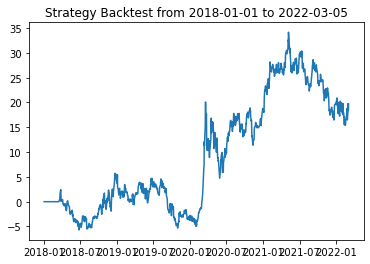

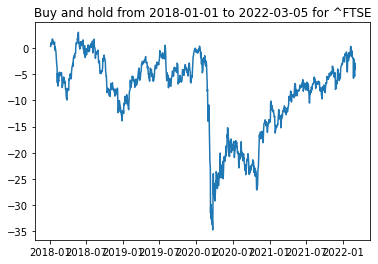

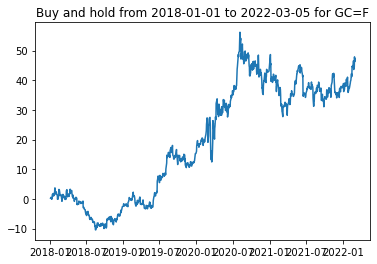

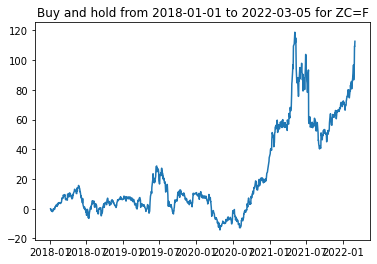

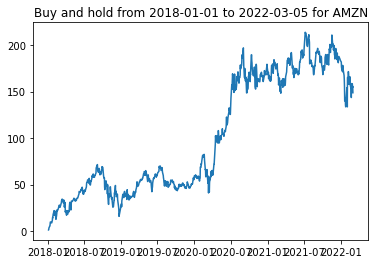

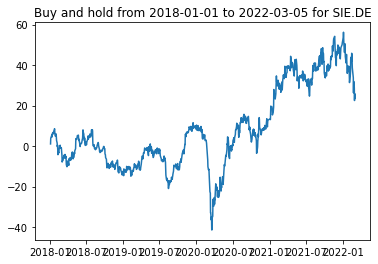

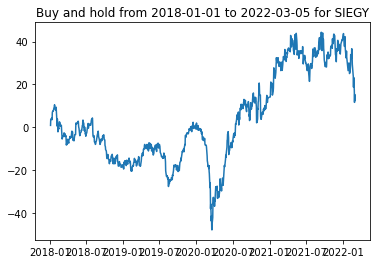

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-25     -0.689976          16.470328
 2022-02-28      1.444062          18.152232
 2022-03-01      1.348912          19.746001
 2022-03-02     -1.096622           18.43284
 2022-03-03      1.116848          19.755555
 
 [1013 rows x 2 columns],
 0.20597836502991695,
 None]

In [9]:
## RUN THIS FOR TESTING ##
testTSM = StrategyTimeSeriesMomentum(["^FTSE","GC=F","ZC=F","AMZN","SIE.DE","SIEGY"])
testTSM.evaluate("2018-01-01","2022-03-05", t=50, fig_other = True)

## Task 2: Relative Momentum Strategy
The aim of this task is to implement a backtest for the relative momentum strategy:

- For each date the strategy will take a long postion in the `p` best previous performing stocks and a short position in the `p` worst performing stocks. 
- The lookback period for which performance will be judged will be the previous `t` days. 
- We will also only adjust our portfolio weights every `q` days.
Note the first date that we can calculate weights will be on date `t + 1` so we aim to adjust our portfolio weights every `q` days after this.

For the worst performing stocks the weights should be negative and for the best performing stocks weights positive such that the sum of the absolute values across each row of the strategy weights is equal to 1! i.e the weights for the worst stocks are -1/(2p) and for the best `p` stocks 1/(2p). All other weights are 0.

For this algorithm performance is measured by cumulative returns.

In [31]:
class StrategyRelativeMomentum(Strategies):
    """
    Implementation of a relative momentum strategy.
    params:
    ------
    start_date, end_date strings of dates
    p = half the number of stocks a postion a is taken in
    t = lookback period length for calculating momentum of each stock
    ------
    """
    def backtest(self, start_date, end_date, p=2, q=14, t=50):
      # imports all code from the parent class
      Strategies.backtest(self, start_date, end_date)
      # Similarly to the TS strat loop through all time steps i and decide a value
      # is a portfolio changing time.
      ######## INSERT CODE HERE #############
        ######## INSERT CODE HERE #############
      for i in range(t, len(self.data)):
          if not (i - t) % q:
          # as before define signals but sort the values in ascending order
          ######## INSERT CODE HERE #############
              signals = pd.Series(data = (100*(self.data["Adj Close"][c][i-1] - self.data["Adj Close"][c][i-t])/
                                                    self.data["Adj Close"][c][i-t] for c in self.codes), index = self.codes).sort_values()
              # display(signals)  
            # display(signals)
          # select and loop through the p code names with a long position
          ######## INSERT CODE HERE #############
              for j in range(len(signals) - p, len(signals)):
            # for each of these codes assign the appropriate weihting to strat
            ######## INSERT CODE HERE #############
                  c = signals.index[j]
                  self.strat.iloc[i][c] = 1 / (2 * p)
          # DO the same for each of the p code names with short postions
          ######## INSERT CODE HERE #############
            ######## INSERT CODE HERE #############
              for j in range(0, p):
                  c = signals.index[j]
                  self.strat.iloc[i][c] = (- 1) / (2 * p)
              # display(self.strat.iloc[i])
        # if the portfolio is not adjusted at time step i then do nothing
        ######## INSERT CODE HERE #############
          else:
            self.strat.iloc[i] = self.strat.iloc[i-1]
      return self.strat


[*********************100%***********************]  6 of 6 completed


PA=F   -9.655963
SI=F   -4.485717
HG=F   -4.453316
GC=F    0.235982
RB=F    9.171346
ZC=F    9.483369
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F    0.25
SI=F   -0.25
PA=F   -0.25
RB=F    0.25
Name: 2018-03-16 00:00:00, dtype: float64

PA=F   -17.094493
SI=F    -3.174131
GC=F    -0.853478
HG=F    -0.647353
RB=F     3.819356
ZC=F    10.889680
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F    0.25
SI=F   -0.25
PA=F   -0.25
RB=F    0.25
Name: 2018-04-06 00:00:00, dtype: float64

PA=F    -1.640179
HG=F    -0.713268
GC=F    -0.519541
SI=F    -0.127218
ZC=F     5.385140
RB=F    23.995727
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.25
Name: 2018-04-26 00:00:00, dtype: float64

GC=F    -3.351826
SI=F    -3.116960
HG=F    -3.012434
PA=F    -0.278298
ZC=F     5.924951
RB=F    14.055140
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F   -0.25
PA=F    0.00
RB=F    0.25
Name: 2018-05-16 00:00:00, dtype: float64

GC=F    -4.112527
ZC=F     0.601604
SI=F     0.805680
RB=F     5.192992
PA=F     5.271297
HG=F    10.386755
dtype: float64

HG=F    0.25
GC=F   -0.25
ZC=F   -0.25
SI=F    0.00
PA=F    0.25
RB=F    0.00
Name: 2018-06-08 00:00:00, dtype: float64

ZC=F   -7.843137
GC=F   -7.027826
PA=F   -5.070914
HG=F   -3.299369
SI=F   -3.138883
RB=F    4.593359
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F   -0.25
SI=F    0.25
PA=F    0.00
RB=F    0.25
Name: 2018-06-28 00:00:00, dtype: float64

ZC=F   -12.915361
HG=F   -10.226714
GC=F    -6.581847
SI=F    -5.665083
PA=F    -5.237376
RB=F    -3.292342
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F   -0.25
SI=F    0.00
PA=F    0.25
RB=F    0.25
Name: 2018-07-19 00:00:00, dtype: float64

HG=F   -11.165129
ZC=F    -8.286951
SI=F    -7.845496
GC=F    -7.217917
PA=F    -6.063730
RB=F    -5.810719
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F   -0.25
SI=F    0.00
PA=F    0.25
RB=F    0.25
Name: 2018-08-08 00:00:00, dtype: float64

HG=F   -12.840341
SI=F    -9.553989
GC=F    -5.265629
PA=F    -3.819479
ZC=F    -2.598315
RB=F     1.703499
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.25
SI=F   -0.25
PA=F    0.00
RB=F    0.25
Name: 2018-08-28 00:00:00, dtype: float64

SI=F   -11.611533
RB=F    -5.948336
HG=F    -4.543852
GC=F    -4.443210
ZC=F     0.000000
PA=F     9.489663
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F    0.25
SI=F   -0.25
PA=F    0.25
RB=F   -0.25
Name: 2018-09-20 00:00:00, dtype: float64

SI=F    -7.171543
RB=F    -3.908602
GC=F    -2.895471
HG=F     0.269064
ZC=F     0.690608
PA=F    16.654061
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F    0.25
SI=F   -0.25
PA=F    0.25
RB=F   -0.25
Name: 2018-10-10 00:00:00, dtype: float64

RB=F    -8.176513
SI=F    -2.177313
ZC=F     0.410678
GC=F     4.106449
HG=F     4.782858
PA=F    24.297696
dtype: float64

HG=F    0.25
GC=F    0.00
ZC=F    0.00
SI=F   -0.25
PA=F    0.25
RB=F   -0.25
Name: 2018-10-30 00:00:00, dtype: float64

RB=F   -19.507962
SI=F     1.981670
GC=F     2.330264
ZC=F     2.601969
HG=F     7.412365
PA=F    19.072792
dtype: float64

HG=F    0.25
GC=F    0.00
ZC=F    0.00
SI=F   -0.25
PA=F    0.25
RB=F   -0.25
Name: 2018-11-19 00:00:00, dtype: float64

RB=F   -32.471924
HG=F    -2.457842
SI=F    -0.991592
GC=F     4.381028
ZC=F     5.052632
PA=F     8.571690
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.25
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2018-12-11 00:00:00, dtype: float64

RB=F   -28.639421
HG=F    -6.100459
ZC=F     2.427512
GC=F     5.324097
SI=F     8.071288
PA=F    16.098648
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.00
SI=F    0.25
PA=F    0.25
RB=F   -0.25
Name: 2019-01-04 00:00:00, dtype: float64

RB=F   -15.770309
HG=F    -2.870118
ZC=F     1.276024
GC=F     4.314143
SI=F     4.887115
PA=F    16.037975
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.00
SI=F    0.25
PA=F    0.25
RB=F   -0.25
Name: 2019-01-25 00:00:00, dtype: float64

HG=F    -0.786841
RB=F     4.807215
ZC=F     5.062413
GC=F     7.319471
SI=F     9.235818
PA=F    19.748786
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.00
SI=F    0.25
PA=F    0.25
RB=F   -0.25
Name: 2019-02-14 00:00:00, dtype: float64

ZC=F    -4.227213
GC=F     2.480457
SI=F     2.880066
HG=F     8.960240
PA=F    25.602392
RB=F    35.705076
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F   -0.25
SI=F    0.00
PA=F    0.25
RB=F    0.25
Name: 2019-03-07 00:00:00, dtype: float64

SI=F    -1.524761
ZC=F    -0.330251
GC=F     1.954858
HG=F     7.749014
PA=F    20.070344
RB=F    43.400790
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F   -0.25
SI=F   -0.25
PA=F    0.25
RB=F    0.25
Name: 2019-03-27 00:00:00, dtype: float64

SI=F    -5.613437
ZC=F    -4.350692
PA=F    -2.125957
GC=F    -2.092368
HG=F     4.973164
RB=F    40.459407
dtype: float64

HG=F    0.25
GC=F    0.00
ZC=F   -0.25
SI=F   -0.25
PA=F    0.00
RB=F    0.25
Name: 2019-04-16 00:00:00, dtype: float64

PA=F   -11.535904
SI=F    -6.116900
ZC=F    -3.981107
HG=F    -3.830514
GC=F    -3.333590
RB=F    29.213050
dtype: float64

HG=F    0.00
GC=F    0.25
ZC=F    0.00
SI=F   -0.25
PA=F   -0.25
RB=F    0.25
Name: 2019-05-07 00:00:00, dtype: float64

PA=F   -13.362852
HG=F    -6.784915
SI=F    -4.805611
GC=F    -1.444158
RB=F     4.134144
ZC=F     8.305425
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.25
Name: 2019-05-28 00:00:00, dtype: float64

RB=F   -10.691277
HG=F    -9.420661
SI=F    -1.721965
GC=F     3.964312
PA=F     8.775736
ZC=F    24.024641
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.25
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2019-06-17 00:00:00, dtype: float64

RB=F    -9.502374
HG=F    -7.610777
SI=F     0.383555
GC=F     9.476399
PA=F    10.390251
ZC=F    24.892086
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.25
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2019-07-08 00:00:00, dtype: float64

RB=F    -6.578230
HG=F    -2.106413
GC=F     9.071972
SI=F    10.757869
ZC=F    13.261164
PA=F    14.413880
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.25
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2019-07-26 00:00:00, dtype: float64

ZC=F   -13.441832
HG=F    -1.541689
RB=F    -1.004258
PA=F     7.069943
GC=F    14.123313
SI=F    16.937784
dtype: float64

HG=F   -0.25
GC=F    0.25
ZC=F   -0.25
SI=F    0.25
PA=F    0.00
RB=F    0.00
Name: 2019-08-15 00:00:00, dtype: float64

ZC=F   -22.681564
RB=F   -18.341148
HG=F    -5.721078
PA=F     1.872782
GC=F     9.569582
SI=F    26.813160
dtype: float64

HG=F    0.00
GC=F    0.25
ZC=F   -0.25
SI=F    0.25
PA=F    0.00
RB=F   -0.25
Name: 2019-09-05 00:00:00, dtype: float64

ZC=F   -13.900057
RB=F   -12.554185
HG=F    -3.861151
GC=F     8.721262
PA=F     8.950284
SI=F    18.698716
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F   -0.25
SI=F    0.25
PA=F    0.25
RB=F   -0.25
Name: 2019-09-25 00:00:00, dtype: float64

RB=F    -6.100122
ZC=F    -1.850709
GC=F     1.850333
HG=F     3.409546
SI=F     7.886213
PA=F    19.651340
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F   -0.25
SI=F    0.25
PA=F    0.25
RB=F   -0.25
Name: 2019-10-15 00:00:00, dtype: float64

GC=F    -1.218392
RB=F     0.785244
SI=F     3.501002
HG=F     4.948535
ZC=F     8.200139
PA=F    22.947773
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2019-11-04 00:00:00, dtype: float64

HG=F   -2.237969
SI=F   -2.213820
GC=F   -1.864649
ZC=F    3.656821
PA=F    8.366137
RB=F    9.741804
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.00
SI=F   -0.25
PA=F    0.25
RB=F    0.25
Name: 2019-11-22 00:00:00, dtype: float64

ZC=F    -5.787781
SI=F    -3.827117
GC=F    -2.090107
RB=F     6.896333
HG=F     9.231974
PA=F    15.861734
dtype: float64

HG=F    0.25
GC=F    0.00
ZC=F   -0.25
SI=F   -0.25
PA=F    0.25
RB=F    0.00
Name: 2019-12-16 00:00:00, dtype: float64

ZC=F    -0.773694
SI=F     3.311069
GC=F     5.121144
HG=F     5.183099
RB=F     6.204974
PA=F    15.932402
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F   -0.25
SI=F   -0.25
PA=F    0.25
RB=F    0.25
Name: 2020-01-07 00:00:00, dtype: float64

RB=F    -8.077308
HG=F    -1.722182
ZC=F     0.727995
SI=F     7.933081
GC=F     8.587568
PA=F    32.045924
dtype: float64

HG=F   -0.25
GC=F    0.25
ZC=F    0.00
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2020-01-28 00:00:00, dtype: float64

HG=F    -1.456130
RB=F    -1.302831
ZC=F     2.440678
SI=F     5.465257
GC=F     7.374488
PA=F    26.486022
dtype: float64

HG=F   -0.25
GC=F    0.25
ZC=F    0.00
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2020-02-18 00:00:00, dtype: float64

RB=F   -19.571508
HG=F    -9.353534
SI=F    -3.057945
ZC=F    -2.645161
GC=F    11.453544
PA=F    32.683478
dtype: float64

HG=F   -0.25
GC=F    0.25
ZC=F    0.00
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2020-03-09 00:00:00, dtype: float64

RB=F   -66.776639
HG=F   -23.066201
SI=F   -18.317246
ZC=F   -10.000000
PA=F     3.680890
GC=F     6.314026
dtype: float64

HG=F   -0.25
GC=F    0.25
ZC=F    0.00
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2020-03-27 00:00:00, dtype: float64

RB=F   -52.560048
ZC=F   -16.021011
SI=F   -11.412147
HG=F   -10.643656
PA=F    -8.490170
GC=F    10.437795
dtype: float64

HG=F    0.00
GC=F    0.25
ZC=F   -0.25
SI=F    0.00
PA=F    0.25
RB=F   -0.25
Name: 2020-04-17 00:00:00, dtype: float64

RB=F   -39.727816
PA=F   -35.403543
SI=F   -15.926174
ZC=F   -15.856950
HG=F    -8.693964
GC=F     2.695119
dtype: float64

HG=F    0.25
GC=F    0.25
ZC=F    0.00
SI=F    0.00
PA=F   -0.25
RB=F   -0.25
Name: 2020-05-07 00:00:00, dtype: float64

ZC=F    -6.831395
HG=F     3.757283
GC=F    12.158176
PA=F    28.031442
RB=F    39.626098
SI=F    41.839771
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F   -0.25
SI=F    0.25
PA=F    0.00
RB=F    0.25
Name: 2020-05-28 00:00:00, dtype: float64

PA=F    -8.682850
ZC=F     0.381388
GC=F     3.136552
HG=F    14.809848
SI=F    16.683210
RB=F    72.078096
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F   -0.25
SI=F    0.25
PA=F   -0.25
RB=F    0.25
Name: 2020-06-17 00:00:00, dtype: float64

PA=F     1.418738
GC=F     5.391666
ZC=F    12.929624
HG=F    17.023507
SI=F    22.544569
RB=F    96.668208
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.00
SI=F    0.25
PA=F   -0.25
RB=F    0.25
Name: 2020-07-08 00:00:00, dtype: float64

ZC=F     1.801096
GC=F    10.128891
HG=F    23.762594
PA=F    26.751591
RB=F    31.385286
SI=F    43.587942
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F   -0.25
SI=F    0.25
PA=F    0.00
RB=F    0.25
Name: 2020-07-28 00:00:00, dtype: float64

ZC=F    -2.037736
RB=F     2.554385
PA=F    10.907294
HG=F    11.693392
GC=F    15.559006
SI=F    49.429567
dtype: float64

HG=F    0.00
GC=F    0.25
ZC=F   -0.25
SI=F    0.25
PA=F    0.00
RB=F   -0.25
Name: 2020-08-17 00:00:00, dtype: float64

RB=F     0.895996
ZC=F     8.589441
GC=F     9.392203
HG=F    11.098593
PA=F    25.869909
SI=F    49.499533
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F   -0.25
SI=F    0.25
PA=F    0.25
RB=F   -0.25
Name: 2020-09-04 00:00:00, dtype: float64

RB=F    -3.095867
HG=F     2.875959
GC=F     3.869467
ZC=F    10.068130
PA=F    10.451189
SI=F    18.572090
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.00
SI=F    0.25
PA=F    0.25
RB=F   -0.25
Name: 2020-09-25 00:00:00, dtype: float64

SI=F    -9.350003
GC=F    -6.390622
RB=F    -2.101731
HG=F     4.671129
PA=F     6.772060
ZC=F    27.491961
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F   -0.25
PA=F    0.25
RB=F    0.00
Name: 2020-10-15 00:00:00, dtype: float64

RB=F   -22.852640
SI=F    -7.423629
GC=F    -0.172615
HG=F     5.322412
PA=F     5.674635
ZC=F    17.681585
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F    0.25
SI=F   -0.25
PA=F    0.25
RB=F   -0.25
Name: 2020-11-04 00:00:00, dtype: float64

SI=F   -13.610766
GC=F    -6.057353
PA=F    -1.857030
RB=F     5.790349
HG=F     6.415281
ZC=F    16.530055
dtype: float64

HG=F    0.25
GC=F   -0.25
ZC=F    0.25
SI=F   -0.25
PA=F    0.00
RB=F    0.00
Name: 2020-11-24 00:00:00, dtype: float64

GC=F    -4.381702
PA=F    -2.587373
SI=F    -2.110033
RB=F    10.468135
ZC=F    10.474308
HG=F    18.785841
dtype: float64

HG=F    0.25
GC=F   -0.25
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.00
Name: 2020-12-15 00:00:00, dtype: float64

GC=F     2.665613
PA=F     4.043665
SI=F    11.954352
HG=F    16.477367
ZC=F    17.292785
RB=F    27.500218
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.25
Name: 2021-01-06 00:00:00, dtype: float64

GC=F    -1.169498
PA=F    -0.799690
SI=F     5.100858
HG=F    15.431122
ZC=F    30.373546
RB=F    36.608771
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.25
Name: 2021-01-27 00:00:00, dtype: float64

GC=F    -3.451656
PA=F     1.972108
SI=F    12.413334
HG=F    12.575452
ZC=F    30.236686
RB=F    42.212880
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.25
Name: 2021-02-19 00:00:00, dtype: float64

GC=F    -8.278656
SI=F     0.216852
PA=F     1.302500
HG=F    16.708900
ZC=F    22.806037
RB=F    55.571646
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F   -0.25
PA=F    0.00
RB=F    0.25
Name: 2021-03-15 00:00:00, dtype: float64

GC=F    -5.880130
SI=F    -2.074110
ZC=F     3.743566
PA=F    11.157984
HG=F    12.500004
RB=F    26.539675
dtype: float64

HG=F    0.25
GC=F   -0.25
ZC=F    0.00
SI=F   -0.25
PA=F    0.00
RB=F    0.25
Name: 2021-04-07 00:00:00, dtype: float64

SI=F    -4.929268
GC=F    -2.876799
RB=F    18.139478
ZC=F    20.709534
HG=F    20.902421
PA=F    24.347012
dtype: float64

HG=F    0.25
GC=F   -0.25
ZC=F    0.00
SI=F   -0.25
PA=F    0.25
RB=F    0.00
Name: 2021-04-27 00:00:00, dtype: float64

SI=F     7.424968
GC=F     8.890573
RB=F    10.713194
HG=F    14.026005
ZC=F    19.627442
PA=F    23.501639
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F   -0.25
PA=F    0.25
RB=F    0.00
Name: 2021-05-19 00:00:00, dtype: float64

PA=F     6.204541
GC=F     9.827796
HG=F     9.833659
SI=F    11.170629
RB=F    16.652603
ZC=F    26.802721
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.25
Name: 2021-06-11 00:00:00, dtype: float64

GC=F     0.305881
SI=F     0.805215
HG=F     1.560099
PA=F     1.583695
RB=F     9.386880
ZC=F    22.033898
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.25
SI=F   -0.25
PA=F    0.00
RB=F    0.25
Name: 2021-07-01 00:00:00, dtype: float64

ZC=F   -26.011000
HG=F   -10.144776
PA=F    -9.422689
SI=F    -8.098460
GC=F    -1.540055
RB=F     4.222113
dtype: float64

HG=F   -0.25
GC=F    0.25
ZC=F   -0.25
SI=F    0.00
PA=F    0.00
RB=F    0.25
Name: 2021-07-22 00:00:00, dtype: float64

ZC=F   -20.254083
SI=F   -16.757467
GC=F    -9.149192
PA=F    -7.249619
HG=F    -6.660235
RB=F     4.492264
dtype: float64

HG=F    0.25
GC=F    0.00
ZC=F   -0.25
SI=F   -0.25
PA=F    0.00
RB=F    0.25
Name: 2021-08-11 00:00:00, dtype: float64

ZC=F   -18.050815
SI=F    -7.899290
PA=F    -3.019734
GC=F     1.526543
HG=F     4.143285
RB=F     5.271071
dtype: float64

HG=F    0.25
GC=F    0.00
ZC=F   -0.25
SI=F   -0.25
PA=F    0.00
RB=F    0.25
Name: 2021-08-31 00:00:00, dtype: float64

PA=F   -34.726161
ZC=F   -22.039597
SI=F   -15.463246
RB=F    -7.113997
HG=F    -4.765206
GC=F    -2.420379
dtype: float64

HG=F    0.25
GC=F    0.25
ZC=F   -0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.00
Name: 2021-09-21 00:00:00, dtype: float64

PA=F   -21.838993
SI=F   -11.160291
HG=F    -4.407995
GC=F    -3.106032
ZC=F    -3.016453
RB=F     0.012677
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F    0.25
SI=F   -0.25
PA=F   -0.25
RB=F    0.25
Name: 2021-10-11 00:00:00, dtype: float64

PA=F   -13.104836
GC=F     1.202114
ZC=F     2.318182
SI=F     3.863055
HG=F     9.879910
RB=F    16.982939
dtype: float64

HG=F    0.25
GC=F   -0.25
ZC=F    0.00
SI=F    0.00
PA=F   -0.25
RB=F    0.25
Name: 2021-10-29 00:00:00, dtype: float64

HG=F    -0.245137
PA=F     1.944100
GC=F     4.022473
SI=F     4.284591
RB=F     8.601225
ZC=F    15.977823
dtype: float64

HG=F   -0.25
GC=F    0.00
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F    0.25
Name: 2021-11-18 00:00:00, dtype: float64

RB=F   -3.624459
PA=F    0.976489
GC=F    3.595703
SI=F    4.338505
HG=F    4.547619
ZC=F    8.487941
dtype: float64

HG=F    0.25
GC=F    0.00
ZC=F    0.25
SI=F    0.00
PA=F   -0.25
RB=F   -0.25
Name: 2021-12-09 00:00:00, dtype: float64

RB=F    -8.232688
HG=F    -6.618588
PA=F    -5.651942
SI=F    -4.249434
GC=F     2.000340
ZC=F    14.191419
dtype: float64

HG=F   -0.25
GC=F    0.25
ZC=F    0.25
SI=F    0.00
PA=F    0.00
RB=F   -0.25
Name: 2021-12-30 00:00:00, dtype: float64

PA=F    -3.383788
SI=F    -1.267477
GC=F     0.859141
HG=F     1.305332
RB=F     5.804838
ZC=F    10.698096
dtype: float64

HG=F    0.00
GC=F    0.00
ZC=F    0.25
SI=F   -0.25
PA=F   -0.25
RB=F    0.25
Name: 2022-01-20 00:00:00, dtype: float64

SI=F     1.736918
GC=F     2.485548
HG=F     2.824532
ZC=F     8.820998
RB=F    26.382930
PA=F    26.717855
dtype: float64

HG=F    0.00
GC=F   -0.25
ZC=F    0.00
SI=F   -0.25
PA=F    0.25
RB=F    0.25
Name: 2022-02-09 00:00:00, dtype: float64

HG=F     6.886513
GC=F     7.683777
SI=F    13.449151
ZC=F    24.694480
PA=F    42.067768
RB=F    45.576660
dtype: float64

HG=F   -0.25
GC=F   -0.25
ZC=F    0.00
SI=F    0.00
PA=F    0.25
RB=F    0.25
Name: 2022-03-02 00:00:00, dtype: float64

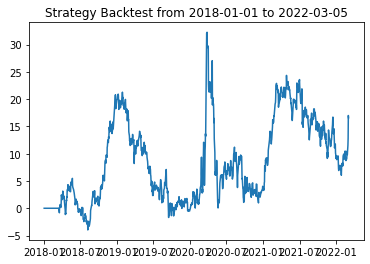

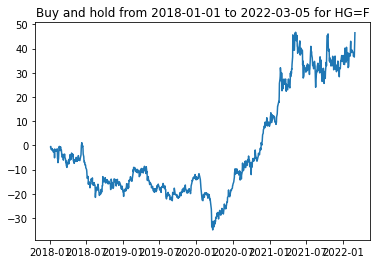

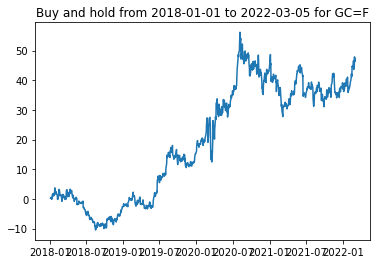

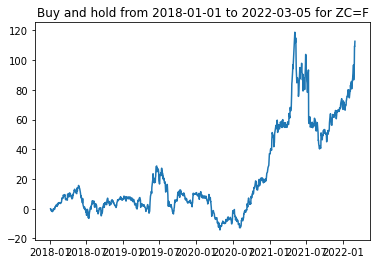

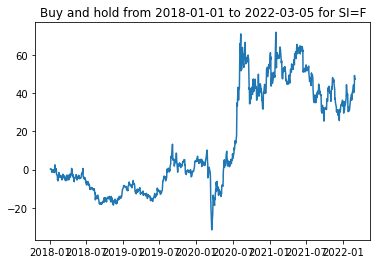

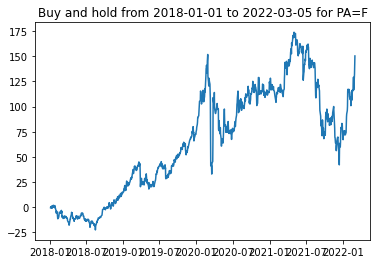

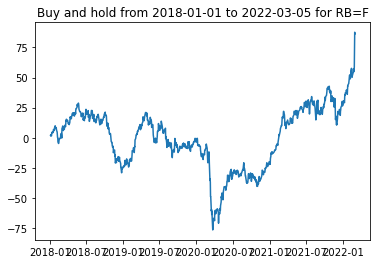

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-25     -0.574999           9.836453
 2022-02-28      1.569238          11.560048
 2022-03-01      1.157458          12.851309
 2022-03-02       3.68213          17.006641
 2022-03-03     -0.357653          16.588163
 
 [1032 rows x 2 columns],
 0.1504061042924144,
 0.20304962648351108]

In [32]:
testRM = StrategyRelativeMomentum(["HG=F","GC=F","ZC=F", "SI=F", "PA=F","RB=F"])
testRM.evaluate("2018-01-01","2022-03-05", t=50, fig_other = True)

## Task 4: RSI Momentum  Strategy with Weighting Extension
This task involves calculating the RSI for each stock and then using this value as a trading signal. From the Powerpoint Slides the formula for the RSI is given by:
 $$\text{RSI} = 1 - \frac{1}{\left(1+\text{abs}\left(\frac{\text{average of previous gains}}{\text{average of previous losses}}\right)\right)}$$

The value of the RSI ranges from 0 to 1.

The RSI is a useful oscillator that indicates the following few things:
If the value of the RSI is close to 0 then this indicates that the asset is underpriced and the asset should be bought. If the RSI is close to one then this indicates it is over priced and the asset should be sold. These low and high boundary values of the RSI are 0.3 and 0.7 respectively


This unweighted algorithm will do the following:
  - Calculate the RSI at each date.
  - If the RSI is less than 0.3 then enter a long position
  - If the RSI is greater than 0.7 then enter a short position
  - If the RSI is somewhere in between then keep the same position as at the previous date
  - The lookback period for which previous average returns will be calculated is given by the parameter `t`
  - The Boolean parameter weighting will, if True, implement a type of user defined weighting strategies or, if False, will weight each stock equally.
  - Note that we want the weightings of the portfolio to only change when the RSI drops below 0.3 or rises above 0.7.

The weighted algorithm will:
 - adjust the portfolio every `q` days where `q` is an extra parameter.
 - weightings will be assigned based on some function of the RSI values.

### Weighting Functions
The weighting function $\text{w(x)}$ in this case will simply be an algebraic function of the RSI value. It is important that this function  maps as follows $\text{w}\left([0,1]\right)\rightarrow [-1,1]$ with $\text{w}(0) > 0,\text{w}(1) < 0$.

Some common examples of these types of weighting functions include various polynomials including the following simple linear polynomial symmetric about $\frac{1}{2}$.
$$w(x) = k_1\left(\frac{1}{2}-x\right)$$

(note the constant $k_1$ above is not necassry to be calculated as when coding we will normalize all the weightings)

One problem with the above function however is that it is symmetric and an investor may wish to use a weighting function that protects against the risks of short selling. So may want to consider the following weighting function:
$$w(x) = k_1\left(\frac{1}{2}+ϵ-x\right) \text{for } ϵ>0$$

Note other weighting methods are also possible that do not involve weighting or smoothing functions but instead use historic data to produce a weighting method.
One such example methods of inverse volatility weighting where i,e assets with a smaller previous standard deviations over a lookback period have a higher weighting.

Note also that the weighting function need not only be a function of the current RSI value but could also depend on previous RSI values.



In [ ]:
class StrategyRSI(Strategies):

  def backtest(self, start_date, end_date, t=14, weighting = False):
    Strategies.backtest(self, start_date, end_date)
    
    # set up a dataframe self.RSI
    RSI = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]),
                              columns = self.codes, index = self.data.index)

  
    # loop through each index using a for loop with index i
    ######## INSERT CODE HERE #############
      # define data_pct_change as a function that calulates the pct change over the previous
      # t time periods. Hint use .pct_change() and dont convert to a percentage after.
      ######## INSERT CODE HERE #############

      # define numerator as the numerator of the RSI values for each asset at time i.
      # package these values into a pd series with index self. codes
      ######## INSERT CODE HERE #############
      
      # similarly define denominator
      ######## INSERT CODE HERE #############

      # loop through self.codes
      ######## INSERT CODE HERE #############

        # calculate the RSI value for each asset at time i.
        # hint carefully consider any potential NaN values.
        ######## INSERT CODE HERE #############
      
        # if no weighting scheme is used set self.strat to be 1 if RSI value < 0.3
        # and self.strat to be -1 for RSI > 0.7 do this for each code at time step i
        # if neither condition is satisfied then set the value equal to previous
        ######## INSERT CODE HERE #############

        # else implement a weighting scheme with the function that re-adjusts self.strat every q days
        # to be 0.8 - RSI 
        ######## INSERT CODE HERE #############

      
      # as before normalize the rows
      ######## INSERT CODE HERE #############
        
    return self.strat

In [ ]:
testRSI = StrategyRSI(["^FTSE","^GSPC","AAPL","GC=F","ZC=F","HG=F","SIEGY","SIE.DE"])
testRSI.evaluate("2018-01-01","2022-03-05", t=21, weighting= True)